In [1]:
import os
import pandas as pd
import polars as pl
import numpy as np
import tensorflow as tf

env = "local"

In [2]:
if env == "local":
    os.chdir("/Users/samuel/Documents/GitHub/QB-GPT/")
else:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/MyDrive/NFL_Challenge/NFL-GPT/NFL data")

In [3]:
os.listdir()

['data_models',
 '.DS_Store',
 'app',
 'LICENSE',
 'models',
 'README.md',
 '.gitignore',
 '.gitattributes',
 'indexv2',
 'data_preprocessing',
 'index',
 '.git',
 'notebooks']

In [4]:
testing_data = tf.data.Dataset.load("data_models/QBGPT/test_tokens_NFL_GPT_v2")

In [5]:
moves_index = pl.read_parquet("indexv2/moves_index.parquet")
position_index = pl.read_parquet("indexv2/positions_index.parquet")
starts_index = pl.read_parquet("indexv2/starts_index.parquet")
scrim_index = pl.read_parquet("indexv2/scrimmage_index.parquet")
playtype_index = pl.read_parquet("indexv2/plays_index.parquet")
time_index = pl.read_parquet("indexv2/time_index.parquet")

In [6]:
class tokenizer:
    def __init__(self, 
                 moves_index : str,
                 play_index : str,
                 positions_index  : str,
                 scrimmage_index : str,
                 starts_index : str,
                 time_index : str,
                 window_size : int):
        self.window = window_size
        
        moves_index = pl.read_parquet(moves_index)
        self.moves_index = self.convert_index_to_dict(moves_index)
        
        play_index = pl.read_parquet(play_index)
        self.play_index= self.convert_index_to_dict(play_index)
        
        positions_index = pl.read_parquet(positions_index)
        self.positions_index = self.convert_index_to_dict(positions_index)
        
        scrimmage_index = pl.read_parquet(scrimmage_index)
        self.scrimmage_index = self.convert_index_to_dict(scrimmage_index)
        
        starts_index = pl.read_parquet(starts_index)
        self.starts_index = self.convert_index_to_dict(starts_index)
        
        time_index = pl.read_parquet(time_index)
        self.time_index = self.convert_index_to_dict(time_index)
        
        self.offdef_index = {0 : ["Def"],
                             1 : ["Off"]}
        
        self.index = {"input_ids" : self.moves_index,
                      "PlayType" : self.play_index,
                      "position_ids" : self.positions_index,
                      "scrim_ids" : self.scrimmage_index,
                      "start_ids" : self.starts_index,
                      "pos_ids" : self.time_index,
                      "OffDef" : self.offdef_index}
    
    def convert_index_to_dict(self, df : pl.DataFrame):
    
        ID_col = [v for v in df.columns if "ID" in v]
        assert len(ID_col) == 1
        new_id_name = ["ID"]

        val_cols = [v for v in df.columns if v not in ID_col+["Cat"]]
        new_val_name = ["Val_"+str(i) for i in range(1, len(val_cols)+1)]

        past_names = ID_col + val_cols
        new_names = new_id_name+new_val_name

        renaming = {past_names[i]: new_names[i] for i in range(len(new_names))}

        d = (df.
                drop("Cat").
                rename(renaming).
                select(new_names).
                to_dict(as_series=False))

        final_d = {d["ID"][i] : [d[k][i] for k in new_val_name] for i in range(len(d["ID"]))}

        return final_d
    
    def base_decode(self,
                    pad_element,
                    inputs : list,
                    index : dict,
                    first : bool):
        if first == True:
            return [index[v][0] if v in index.keys() else pad_element for v in inputs]
        else:
            return [index[v] if v in index.keys() else pad_element for v in inputs]
        
    def decode(self,
               inputs : list,
               type : str):
        if type in ["input_ids", "start_ids"]:
            padding = [-1000, -1000]
        elif type in ["scrim_ids", "pos_ids"]:
            padding = -1000
        else:
            padding = "[PAD]"
        
        if type in ["input_ids", "start_ids"]:
            return self.base_decode(padding, inputs, index = self.index[type], first=False)
        else:
            return self.base_decode(padding, inputs, index = self.index[type], first=True)

    def find_id_by_values(self, 
                          input_dict : dict, 
                          target_list : list):
        
        for key, values in input_dict.items():
            if set(target_list) == set(values):
                return key
        
    def base_encode(self,
                inputs : list,
                index : dict):
        return [self.find_id_by_values(index, [v]) for v in inputs]
    
    def encode(self,
               inputs : list,
               type : str):
        return self.base_encode(inputs, index = self.index[type])
    
    def decode_sequence(self,
                        input : dict):
        return {k : self.decode(v, k) if k not in ["side_ids", "token_type_ids", "labels", "attention_mask", "ids"] else v for k,v in input.items()}
    
    def encode_sequence(self,
                        input : dict):
        return {k : self.encode(v, k) if k not in ["side_ids", "token_type_ids", "labels", "attention_mask", "ids"] else v for k,v in input.items()}
    
    def truncate_to_time_t(self,
                           input : dict,
                           t : int):
        to_keep = [i < t for i in input["pos_ids"]]
        return {k: [v[i] for i in range(len(v)) if to_keep[i] == True] for k,v in input.items()}
    
    def resize_window(self,
                      input : dict,
                      pos_id):
        out = input.copy()
        out["attention_mask"] = [0 if out["pos_ids"][p] <pos_id else 1 for p in range(len(out["pos_ids"]))]
        return out
    
    def prepare_for_call(self, 
                         input : dict):
        resize_limit = max([v for v in np.array(input["pos_ids"]).flatten() if v != 51]) - self.window
        if resize_limit > 0:
            input = self.resize_window(input, resize_limit)
        
        done = {k : tf.constant(v) for k,v in input.items()}
        if len(done["pos_ids"].shape) == 1:
            done = {k : tf.expand_dims(v, axis=0) for k,v in input.items()}
        return done        

In [7]:
qb_tok = tokenizer(moves_index="indexv2/moves_index.parquet",
                   play_index="indexv2/plays_index.parquet",
                   positions_index="indexv2/positions_index.parquet",
                   scrimmage_index="indexv2/scrimmage_index.parquet",
                   starts_index="indexv2/starts_index.parquet",
                   time_index="indexv2/time_index.parquet",
                   window_size=20)

In [8]:
from models.modeling.QBGPT.models import QBGPT, LargeQBGPT

moves_to_pred = 11170
input_size = 11172
starts_size = 1954
scrimmage_size = 100
positions_id = 29

temp_ids = 52
off_def_size = 2
token_type_size = 3
play_type_size = 9

model_medium = QBGPT(input_vocab_size = input_size,
                    positional_vocab_size = temp_ids,
                    position_vocab_size=positions_id,
                    start_vocab_size=starts_size,
                    scrimmage_vocab_size=scrimmage_size,
                    offdef_vocab_size = off_def_size,
                    type_vocab_size = token_type_size,
                    playtype_vocab_size = play_type_size,
                    embedding_dim = 256,
                    hidden_dim = 256,
                    num_heads = 3,
                    diag_masks = False,
                    to_pred_size = moves_to_pred)

model_medium.load_weights("models/modeling/QBGPT/weights/model_mediumv2/QBGPT")

In [60]:
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.array([np.random.multinomial(1, pred, 1) for pred in predictions])
    return np.argmax(probas, axis=-1)

In [81]:
class generator:
    def __init__(self,
                 model,
                 tokenizer):
        
        self.QBGPT = model
        self.tokenizer = tokenizer
        
    def get_unique_lists(self,
                         l_of_ls : list):
        list_of_tuples = [tuple(inner_list) for inner_list in l_of_ls]
        
        # Create a set to eliminate duplicate
        unique_tuples = set(list_of_tuples)
        
        # Convert unique tuples back to lists
        unique_lists = [list(unique_tuple) for unique_tuple in unique_tuples]
        
        return unique_lists
                
    def cut(self, l, ref):
        splitted = []
        cutted = []
        for i in range(len(l)):
            if ref[i] == True:
                cutted.append(l[i])
            else:
                splitted.append(cutted)
                cutted = []
                cutted.append(l[i])     
            if i == len(l)-1:
                splitted.append(cutted) 
        return splitted
        
    def get_last_preds(self,
                       logits,
                       input : dict):
        
        to_keep = [i == max(input["pos_ids"]) for i in input["pos_ids"]]
        return np.array([logits[i] for i in range(len(logits)) if to_keep[i] == True])
        
    def get_logits(self, 
                   input : dict):
        x = self.tokenizer.prepare_for_call(input)
        return self.QBGPT(x)
    
    def convert_to_preds(self,
                         logits):
        preds = tf.squeeze(logits, axis=0)
        return preds
    
    def set_temperature(self, 
                        x):
        if x < 5:
            return 10
        elif x < 10 and x >= 5:
            return 5
        elif x <20 and x >= 10:
            return 2
        else: 
            return 1.5
        
    def draw_random(self, 
                    logit_one_batch):
        return np.array([np.random.multinomial(1, pred, 1) for pred in logit_one_batch])
    
    def sample_next(self,
                    predictions, 
                    temperature : int):
        predictions = np.asarray(predictions).astype("float64")
        predictions = np.log(predictions) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        probas = np.array([self.draw_random(pred) for pred in predictions])
        return np.argmax(probas, axis=-1)
    
    def generate(self,
                 input : dict):
        logits = self.get_logits(input)
        temperature_parameter = max(input["pos_ids"])
        processed_logits = self.sample_next(logits, temperature=temperature_parameter)
        preds = self.convert_to_preds(processed_logits)
        return self.get_last_preds(preds, input)
    
    def slice_inputs(self,
                     input : dict):
        flags = [True] + [input["pos_ids"][i+1] > input["pos_ids"][i] for i in range(len(input["pos_ids"])-1)]
        cutted_inputs = {k : self.cut(v, flags) for k,v in input.items()}
        return cutted_inputs
    
    def continue_by_token(self, 
                         arr,
                         token :str):
        if token == "input_ids":
            return arr
        if token == "pos_ids":
            insert = max(arr)+1
            return np.concatenate([arr, np.array([insert])])
        elif token == "token_type_ids":
            return  np.concatenate([arr, np.array([1])])
        else:
            return  np.concatenate([arr, [arr[-1]]])
            
        
    def append_prediction(self,
                           arr,
                           pred):
        return np.concatenate([arr, [pred]])
    
    def append_predictions(self,
                           d : dict,
                           preds):
        new = d.copy()
        new["input_ids"] = [self.append_prediction(new["input_ids"][i], preds[i]) for i in range(len(preds))]
        return new
                
    def merge_cuts(self, 
                   input : dict):
        return {k : np.concatenate(v) for k,v in input.items()}
        
    def update_inputs(self,
                      input,
                      preds):
        sliced = self.slice_inputs(input)
        appended = self.append_predictions(sliced, preds)
        continued = {k : [self.continue_by_token(e, k) for e in v] for k,v in appended.items()}
        merged = self.merge_cuts(continued)
        return merged
    
    def generate_sequence(self,
                          input,
                          t):
        new_input = input.copy()
        for i in range(t):
            generated = self.generate(new_input)
            new_input = self.update_inputs(new_input, generated)
        return new_input
    
    def convert_list(self,
                     d,
                     keep_original):
        new_df = d.copy()
        new_df["start_ids_x"] = [v[0] for v in new_df["start_ids"]]
        new_df["start_ids_y"] = [v[1] for v in new_df["start_ids"]]
        new_df["input_ids_x"] = [v[0] for v in new_df["input_ids"]]
        new_df["input_ids_y"] = [v[1] for v in new_df["input_ids"]]
        if keep_original == True:
            return new_df
        else:
            return {k : v for k,v in new_df.items() if k not in ["start_ids", "input_ids"]}
        
    def remove_pad(self,
                   seq):
        df = pd.DataFrame(seq)
        filtered = df[df["start_ids_x"] != -1000].reset_index(drop=True)
        filtered = df[df["input_ids_x"] != -1000].reset_index(drop=True)
        return filtered.to_dict(orient = "list")
    
    def _compute_true_sequence(self,
                          scrimmage_line,
                          start : list,
                          moves : list):
        scrimmage = np.array([scrimmage_line, 26.5])
        
        updated_moves = np.array([np.array(start) + np.array(v) for v in moves])
        
        appended = np.concatenate([np.expand_dims(start, axis = 0), updated_moves])
        
        final = appended + scrimmage
        return final
    
    def compute_true_sequence(self,
                              scrims,
                              starts,
                              moves):
        return self._compute_true_sequence(np.unique(scrims)[0], self.get_unique_lists(starts)[0], moves)
    
    def _resize_variable(self,
                         x, 
                         ref: str):
        
        if ref in ["pos_ids", "token_type_ids"]:
            return np.concatenate([[0], x])
        
        elif ref in ["input_ids", "start_ids"]:
            return np.vstack([self.get_unique_lists(x)[0], x])
        
        else:
            return np.concatenate([np.unique(x), x])
    
    def prepare_for_plot(self, 
                         seq):
        sequence = seq.copy()
        sequence = self.convert_list(sequence, keep_original = True)
        sequence = self.remove_pad(sequence)
        cutted = self.slice_inputs(sequence)
        moves_updated = [self.compute_true_sequence(cutted["scrim_ids"][i], cutted["start_ids"][i], cutted["input_ids"][i]) for i in range(len(cutted["input_ids"]))]
        cutted["input_ids"] = moves_updated
        cutted = {k : [self._resize_variable(e, k) if k != "input_ids" else e for e in v] for k,v in cutted.items()}
        cutted["ids"] = [[i for e in range(len(cutted["input_ids"][i]))] for i in range(len(cutted["input_ids"]))]
        merged = self.merge_cuts(cutted)
        converted = self.convert_list(merged, keep_original = False)
        return {k:v for k,v in converted.items() if k != "labels"}
    
    def insert_ids(self,
                   input):
        
        cutted = self.slice_inputs(input)
        cutted["ids"] = [[i for e in range(len(cutted["input_ids"][i]))] for i in range(len(cutted["input_ids"]))]
        merged = self.merge_cuts(cutted)
        return merged


In [4]:
import tensorflow as tf
import numpy as np

tf.nn.softmax(np.array([0.8, 0.0, 0.12]))

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.51126157, 0.22972463, 0.2590138 ])>

In [82]:
gen_test = generator(model=model_medium,
                     tokenizer=qb_tok)

In [74]:
essai = list(testing_data)
essai = [v[0] for v in essai if v[0]["pos_ids"].numpy()[0] == 0]
essai = [v for v in essai if np.unique(v["PlayType"])[0] in [4, 7]]

In [75]:
essai_l = {k : v.numpy() for k,v in essai[44].items()}

In [76]:
true = essai_l.copy()
true["input_ids"] = true["labels"]
true = {k:v for k,v in true.items() if k != "labels"}

In [77]:
trial = qb_tok.prepare_for_call(essai[44])
embed_trial = model_medium.Encoder.Embedding(trial)
norm_trial = model_medium.Encoder.Attention1.NormIn(embed_trial)
key_trial = model_medium.Encoder.Attention1.Key(norm_trial)
keys_trial = model_medium.Encoder.Attention1.transpose_for_scores(key_trial, 1)
value_trial = model_medium.Encoder.Attention1.Value(norm_trial)
values_trial = model_medium.Encoder.Attention1.transpose_for_scores(value_trial, 1)
query_trial = model_medium.Encoder.Attention1.Query(norm_trial)
queries_trial = model_medium.Encoder.Attention1.transpose_for_scores(query_trial, 1)

attention_weights_trial = model_medium.Encoder.Attention1.compute_attention_weigths(queries_trial, keys_trial, trial["pos_ids"], trial["attention_mask"])
attention_scores_trial = tf.matmul(attention_weights_trial, values_trial)
#attention_scores_trial = tf.transpose(attention_scores, perm=[0, 2, 1, 3])
#attention_scores_trial = tf.reshape(tensor=attention_scores, shape=(batch_size, -1, self.total_dim))


trial_d = qb_tok.truncate_to_time_t(essai_l, 10)
compare = qb_tok.prepare_for_call(trial_d)
embed_compare = model_medium.Encoder.Embedding(compare)
norm_compare = model_medium.Encoder.Attention1.NormIn(embed_compare)
key_compare = model_medium.Encoder.Attention1.Key(norm_compare)
keys_compare = model_medium.Encoder.Attention1.transpose_for_scores(key_compare, 1)
value_compare = model_medium.Encoder.Attention1.Value(norm_compare)
values_compare = model_medium.Encoder.Attention1.transpose_for_scores(value_compare, 1)
query_compare = model_medium.Encoder.Attention1.Query(norm_compare)
queries_compare = model_medium.Encoder.Attention1.transpose_for_scores(query_compare, 1)

attention_weights_compare = model_medium.Encoder.Attention1.compute_attention_weigths(queries_compare, keys_compare, compare["pos_ids"], compare["attention_mask"])
attention_scores_compare = tf.matmul(attention_weights_compare, values_compare)
#attention_scores_compare = tf.transpose(attention_scores, perm=[0, 2, 1, 3])
#attention_scores_compare = tf.reshape(tensor=attention_scores, shape=(batch_size, -1, self.total_dim))

<Axes: >

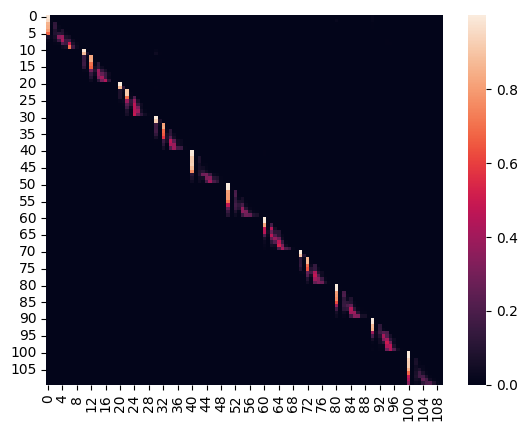

In [78]:
import seaborn as sns 
sns.heatmap(attention_weights_compare[0][0])

<Axes: >

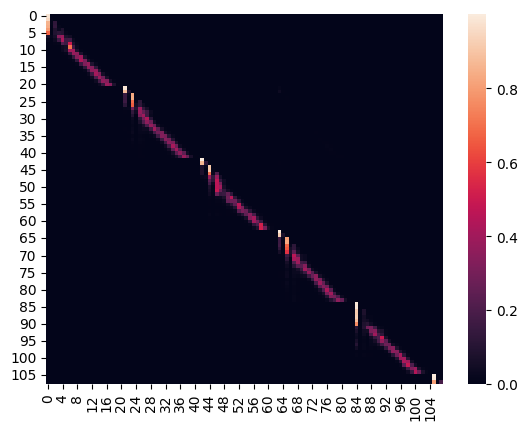

In [79]:
sns.heatmap(attention_weights_trial[0][0][:108,:108])

In [85]:
essai_l = {k : v.numpy() for k,v in essai[456].items()}
trial_d = qb_tok.truncate_to_time_t(essai_l, 10)
logits = gen_test.get_logits(trial_d)

In [87]:
tf.reduce_sum(tf.nn.relu(logits), axis=-1)

<tf.Tensor: shape=(1, 70), dtype=float32, numpy=
array([[11.898662 , 23.81514  , 28.525215 , 26.878733 , 25.869896 ,
        22.50302  , 19.980839 , 10.948641 ,  9.713671 , 21.490986 ,
        10.943792 , 19.299885 , 21.867447 , 19.89249  , 19.956303 ,
        18.694681 , 16.358202 , 14.920481 , 15.194433 , 16.199286 ,
        11.070715 , 18.482456 , 17.00481  , 14.981085 , 15.63286  ,
        15.043182 , 14.128849 , 13.388034 , 14.11964  , 16.271547 ,
        15.920626 , 13.976971 , 15.745935 , 15.782389 , 16.826015 ,
        15.749194 , 16.369184 , 15.89748  , 16.51753  , 16.986332 ,
        14.881386 , 16.192812 , 16.463535 , 14.641907 , 15.838584 ,
        15.409054 , 15.4025955, 14.776443 , 14.572324 , 15.209827 ,
        12.781362 , 18.1206   , 15.182493 , 16.033415 , 18.566542 ,
        16.783596 , 15.026274 , 16.475836 , 18.217785 , 14.041685 ,
        12.597633 , 15.866331 , 16.794731 , 16.32248  , 16.14634  ,
        14.724125 , 19.306078 , 17.084091 ,  9.68376  , 14.0577545]

In [ ]:
 predictions = np.asarray(logits).astype("float64")
predictions = np.log(predictions) / temperature
exp_preds = np.exp(predictions)
predictions = exp_preds / np.sum(exp_preds)

In [83]:
essai_l = {k : v.numpy() for k,v in essai[456].items()}

trial_d = qb_tok.truncate_to_time_t(essai_l, 10)
generated = gen_test.generate_sequence(trial_d, 30)
decoded = gen_test.tokenizer.decode_sequence(generated)

step1 = gen_test.prepare_for_plot(decoded)
plot = pd.DataFrame(step1)

decoded_true = gen_test.tokenizer.decode_sequence(essai_l)
step1_true = gen_test.prepare_for_plot(decoded_true)
plot_true = pd.DataFrame(step1_true)

/var/folders/xc/clt_qlgj3cncjzx754k5yw_c0000gn/T/ipykernel_41835/3468056134.py:71: RuntimeWarning:

invalid value encountered in log



ValueError: pvals < 0, pvals > 1 or pvals contains NaNs

In [20]:
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
from PIL import Image

fig = px.line(plot, x="input_ids_x", y="input_ids_y", animation_frame="pos_ids", color="OffDef", symbol="ids",
                 text="position_ids", title="Player Trajectories Over Time",
                 range_x=[0, 140], range_y=[0, 60], # Set X and Y axis ranges
                 line_shape="linear",  # Draw lines connecting points
                 render_mode="svg")  # Render mode for smoother lines

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='lines'))
fig.update_layout(width=800, height=600) 

In [19]:
fig.write_html("essai.html")

In [16]:
import plotly.graph_objs as go
from plotly_gif import GIF, two_d_time_series

gif = GIF()
two_d_time_series(gif, fig)

  Image 1 captured. (elapsed time: 0.0 min; 0 sec)
  Image 2 captured. (elapsed time: 0.0 min; 0 sec)
  Image 3 captured. (elapsed time: 0.0 min; 0 sec)
  Image 4 captured. (elapsed time: 0.0 min; 0 sec)
  Image 5 captured. (elapsed time: 0.0 min; 0 sec)
  Image 6 captured. (elapsed time: 0.0 min; 0 sec)
  Image 7 captured. (elapsed time: 0.0 min; 0 sec)
  Image 8 captured. (elapsed time: 0.0 min; 0 sec)
  Image 9 captured. (elapsed time: 0.0 min; 0 sec)
  Image 10 captured. (elapsed time: 0.0 min; 0 sec)
  Image 11 captured. (elapsed time: 0.0 min; 0 sec)
  Image 12 captured. (elapsed time: 0.0 min; 0 sec)
  Image 13 captured. (elapsed time: 0.0 min; 0 sec)
  Image 14 captured. (elapsed time: 0.0 min; 0 sec)
  Image 15 captured. (elapsed time: 0.0 min; 0 sec)
  Image 16 captured. (elapsed time: 0.0 min; 0 sec)
  Image 17 captured. (elapsed time: 0.0 min; 0 sec)
  Image 18 captured. (elapsed time: 0.0 min; 1 sec)
  Image 19 captured. (elapsed time: 0.0 min; 1 sec)
  Image 20 captured. 

In [313]:
fig = px.line(plot_true, x="input_ids_x", y="input_ids_y", animation_frame="pos_ids", color="OffDef", symbol="ids",
                 text="position_ids", title="Player Trajectories Over Time",
                 range_x=[0, 140], range_y=[0, 60], # Set X and Y axis ranges
                 line_shape="linear",  # Draw lines connecting points
                 render_mode="svg")  # Render mode for smoother lines

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='lines'))
fig.update_layout(width=800, height=600) 

In [38]:
import plotly.express as px

fig = px.line(plot, x="input_ids_x", y="input_ids_y", animation_frame="pos_ids", color="OffDef", symbol="ids",
                 text="position_ids", title="Player Trajectories Over Time",
                 range_x=[0, 140], range_y=[0, 60], # Set X and Y axis ranges
                 line_shape="linear",  # Draw lines connecting points
                 render_mode="svg")  # Render mode for smoother lines

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='lines'))
fig.update_layout(width=800, height=600) 

In [308]:
fig = px.scatter(essai, x="input_ids_x", y="input_ids_y", animation_frame="pos_ids", color="OffDef", symbol="position_ids",
                 text="position_ids", title="Player Trajectories Over Time")

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='markers+lines'))
fig.update_layout(width=800, height=600) 
fig.update_xaxes(range=[0, 120])
fig.update_yaxes(range=[0, 60])

fig.show()

In [303]:
import plotly.express as px

# Sample data in a Pandas DataFrame (replace this with your actual data)
data = pd.DataFrame({
    "ID": [1, 2, 3, 4, 5, 6, 7, 8],
    "OffDef": ["Off", "Off", "Off", "Off", "Def", "Def", "Def", "Def"],
    "X": [1, 3, 5, 7, 2, 4, 6, 8],
    "Y": [2, 4, 6, 8, 1, 3, 5, 7],
    "positions": ["A", "B", "C", "D", "X", "Y", "Z", "W"],
    "time": [0, 1, 2, 3, 0, 1, 2, 3]  # Replace this with your time data
})

# Create an animated Plotly scatter plot
fig = px.scatter(data, x="X", y="Y", animation_frame="time", color="OffDef", symbol="OffDef",
                 text="positions", title="Player Trajectories Over Time")

# Customize the appearance of the plot
fig.update_traces(marker=dict(size=10), selector=dict(mode='markers+lines'))

fig.show()